In [19]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/allenai/sciq/" + splits["train"])
df

,question,distractor3,distractor1,distractor2,correct_answer,support
0,What type of organism is commonly used in prep...,viruses,protozoa,gymnosperms,mesophilic organisms,"Mesophiles grow best in moderate temperature, ..."
1,What phenomenon makes global winds blow northe...,tropical effect,muon effect,centrifugal effect,coriolis effect,Without Coriolis Effect the global winds would...
2,Changes from a less-ordered state to a more-or...,endothermic,unbalanced,reactive,exothermic,Summary Changes of state are examples of phase...
3,What is the least dangerous radioactive decay?,zeta decay,beta decay,gamma decay,alpha decay,All radioactive decay is dangerous to living t...
4,Kilauea in hawaii is the world’s most continuo...,magma,greenhouse gases,carbon and smog,smoke and ash,Example 3.5 Calculating Projectile Motion: Hot...
...,...,...,...,...,...,...
11674,The enzyme pepsin plays an important role in t...,lipids,protons,proteins,peptides,Protein A large part of protein digestion take...
11675,What remains a constant of radioactive substan...,acidity,temperature,volatility,rate of decay,The rate of decay of a radioactive substance i...
11676,"Terrestrial ecosystems, also known for their d...",substrates,bisomes,monomes,biomes,"Terrestrial ecosystems, also known for their d..."
11677,High explosives create shock waves that exceed...,turbulence,light speed,ion speed,supersonic,The modern day formulation of gun powder is ca...


In [2]:
df.loc[0]

question          What type of organism is commonly used in prep...
distractor3                                                 viruses
distractor1                                                protozoa
distractor2                                             gymnosperms
correct_answer                                 mesophilic organisms
support           Mesophiles grow best in moderate temperature, ...
Name: 0, dtype: object

In [3]:
import torch
import os

from sentence_transformers import CrossEncoder
from src.chain_initialisation import init_chain
from src.embedding_management import init_embeddings, add_embeddings_from_files
from src.model_initialisation import init_model
from src.pipeline_initialisation import init_pipeline
from src.retriever_initialisation import init_retriever
from src.dynamic_doc_retrieval import download_documents, initialise_keyword_model, generate_query_from_question

2025-05-28 15:39:21.099936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748439561.497858   47729 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748439561.535620   47729 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748439561.631152   47729 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748439561.631244   47729 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748439561.631254   47729 computation_placer.cc:177] computation placer alr

In [4]:
BASE_DIR = os.curdir
DATA_DIR = os.path.join(BASE_DIR, "data")
DYNAMIC_DATA_DIR = os.path.join(DATA_DIR, "dynamic")
print(f"dynamic data dir: {DYNAMIC_DATA_DIR}")


def rerank_documents(reranker, query: str, documents: list, top_k: int = 3, min_score = 0.5) -> list:
    if not documents:
        return []

    pairs = [(query, doc.page_content) for doc in documents]
    scores = reranker.predict(pairs)
    ranked = sorted(zip(documents, scores), key=lambda x: x[1], reverse=True)

    return [doc for doc, score in ranked[:top_k] if score > min_score]

def ask_question(model_chain, reranker, keyword_model, vectorstore, question, num_docs, max_tries, online, rerank_top_k, rerank_min_score):
    if online:
        print("Obtaining data from scholar...")
        query = generate_query_from_question(keyword_model, question)
        downloaded_files = download_documents(query, DYNAMIC_DATA_DIR, num_docs, max_tries)
        add_embeddings_from_files(vectorstore, downloaded_files)

    response = model_chain.invoke({
        "question": question,
        "chat_history": []
    })
    answer = response["answer"].split("### Answer:")[-1].strip()
    source_documents = response["source_documents"]
    filtered_docs = rerank_documents(reranker, question, source_documents, rerank_top_k, rerank_min_score)
    return answer, source_documents, filtered_docs

dynamic data dir: ./data/dynamic


In [5]:
cuda_available = torch.cuda.is_available()
print(f"Initializing model... CUDA available: {cuda_available}")
model, model_name = init_model(cuda_available)
pipeline = init_pipeline(model=model, model_name=model_name)
vectorstore = init_embeddings(cuda_available)
retriever = init_retriever(vectorstore)
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
chain = init_chain(pipeline=pipeline, retriever=retriever)
keyword_model = initialise_keyword_model()
print("Start-up complete.")

Initializing model... CUDA available: False


Device set to use cpu
/home/henri/ul-fri-nlp-course-project-2024-2025-drop-table-teams/src/embedding_management.py:17: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(


Loading FAISS from file - skipping embedding build.
Vectorstore loaded successfully.
Retriever initialized with k=2 and similarity threshold=0.8


/home/henri/ul-fri-nlp-course-project-2024-2025-drop-table-teams/src/chain_initialisation.py:7: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipeline)


LLM model chain created.
Start-up complete.


In [7]:
from sentence_transformers import SentenceTransformer, util
from fuzzywuzzy import fuzz

# Initialize embedding model
evaluation_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
def evaluate_answer(row, chain, reranker, keyword_model, vectorstore, num_docs, max_tries, online, rerank_top_k, rerank_min_score):
    question = row['question']
    correct_answer = row['correct_answer']
    support = row['support']
    distractors = [row['distractor1'], row['distractor2'], row['distractor3']]

    # Chatbot answer
    response, source_docs, filtered_docs = ask_question(chain, reranker, keyword_model, vectorstore, question, num_docs, max_tries, online, rerank_top_k, rerank_min_score)
    response = response.lower()

    # Exact match
    exact = int(correct_answer.lower() in response)

    # Fuzzy match
    fuzzy_score = fuzz.partial_ratio(correct_answer.lower(), response)

    # Embedding similarity to correct answer
    emb_correct = evaluation_model.encode(correct_answer, convert_to_tensor=True)
    emb_response = evaluation_model.encode(response, convert_to_tensor=True)
    sim_correct = util.cos_sim(emb_correct, emb_response).item()

    # Embedding similarity to support passage
    emb_support = evaluation_model.encode(support, convert_to_tensor=True)
    sim_support = util.cos_sim(emb_support, emb_response).item()

    # Compare similarity to distractors
    sim_distractors = []
    for d in distractors:
        emb_distractor = evaluation_model.encode(d, convert_to_tensor=True)
        sim_distractors.append(util.cos_sim(emb_distractor, emb_response).item())
    
    # Is chatbot closer to correct than to all distractors?
    correct_beats_distractors = int(sim_correct > max(sim_distractors))

    return {
        "question": question,
        "chatbot_response": response,
        "exact_match": exact,
        "fuzzy_score": fuzzy_score,
        "sim_to_correct": round(sim_correct, 3),
        "sim_to_support": round(sim_support, 3),
        "correct_beats_distractors": correct_beats_distractors,
        "source_docs": source_docs,
        "filtered_docs": filtered_docs,
    }


In [14]:
for i, row in df[:3].iterrows():
    print(row["question"])

What type of organism is commonly used in preparation of foods such as cheese and yogurt?
What phenomenon makes global winds blow northeast to southwest or the reverse in the northern hemisphere and northwest to southeast or the reverse in the southern hemisphere?
Changes from a less-ordered state to a more-ordered state (such as a liquid to a solid) are always what?


In [ ]:

configs = [
    {"k": 3, "th": 0.7},
    {"k": 3, "th": 0.9},
    {"k": 5, "th": 0.7},
    {"k": 5, "th": 0.85},
    {"k": 10, "th": 0.7},
    {"k": 10, "th": 0.9},
]

rerank_configs = [
    {"top_k": 2, "min_score": 0.3},
    {"top_k": 3, "min_score": 0.5},
    {"top_k": 5, "min_score": 0.6},
]


for config in configs:
    retriever = init_retriever(vectorstore, k=config["k"], th=config["th"])
    reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
    chain = init_chain(pipeline=pipeline, retriever=retriever)
    keyword_model = initialise_keyword_model()
    num_docs: int = int(os.getenv("num_docs"))
    max_tries: int = int(os.getenv("max_tries"))
    print("Start-up complete.")
    for online in [False, True]:
        for rerank_conf in rerank_configs:
            results = []
            filename = f"k_{config['k']}-thresh_{config['th']}-online_{online}-top_k_{rerank_conf['top_k']}-min_score_{rerank_conf['min_score']}.csv"
            for i, row in df[:20].iterrows():
                result = evaluate_answer(row, chain, reranker, keyword_model, vectorstore, num_docs, max_tries, online, rerank_conf["top_k"], rerank_conf["min_score"])
                results.append(result)
            
            results_df = pd.DataFrame(results)
            results_df.to_csv(f"{drive_path}/{filename}", index=False)

Retriever initialized with k=3 and similarity threshold=0.7
LLM model chain created.


/home/henri/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:1082: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='8f444c83-58e6-4f42-a652-38cac1d27915', metadata={'source': './data/dynamic/Yogurt_as_probiotic_carrier_food.pdf'}, page_content='sugar, fruit, ﬂavours, colouring, emulsiﬁers, stabilisers,\nand\nspeciﬁc\npure\ncultures\nof\nlactic\nacid\nbacteria\nA. Lourens-Hattingh, B.C. Viljoen / International Dairy Journal 11 (2001) 1–17\n7\n(S. thermophilus and L. bulgaricus) to conduct the\nfermentation process. The basic process of yogurt\nproduction is outlined in Fig. 3.\nS. thermophilus and L. bulgaricus exhibit a symbiotic\nrelationship during the processing of yogurt, with the\nratio between the species changing constantly (Radke-'), np.float32(-18.569504)), (Document(id='4a79e568-c772-47aa-aa72-df82ef8f3dc0', metadata={'source': './data/dynamic/Yogurt_as_probiotic_carrier_food.pdf'}, page_content='sugar, fruit, ﬂavours, colouring

Start-up complete.


/home/henri/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:1082: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='8f444c83-58e6-4f42-a652-38cac1d27915', metadata={'source': './data/dynamic/Yogurt_as_probiotic_carrier_food.pdf'}, page_content='sugar, fruit, ﬂavours, colouring, emulsiﬁers, stabilisers,\nand\nspeciﬁc\npure\ncultures\nof\nlactic\nacid\nbacteria\nA. Lourens-Hattingh, B.C. Viljoen / International Dairy Journal 11 (2001) 1–17\n7\n(S. thermophilus and L. bulgaricus) to conduct the\nfermentation process. The basic process of yogurt\nproduction is outlined in Fig. 3.\nS. thermophilus and L. bulgaricus exhibit a symbiotic\nrelationship during the processing of yogurt, with the\nratio between the species changing constantly (Radke-'), np.float32(-18.569504)), (Document(id='4a79e568-c772-47aa-aa72-df82ef8f3dc0', metadata={'source': './data/dynamic/Yogurt_as_probiotic_carrier_food.pdf'}, page_content='sugar, fruit, ﬂavours, colouring

IndexError: index out of range in self

In [17]:
if not os.path.exists("evaluation"):
    os.makedirs("evaluation")
results_df.to_csv(f"evaluation/{title}.csv", index=False)
results_df

,question,chatbot_response,exact_match,fuzzy_score,sim_to_correct,sim_to_support,correct_beats_distractors,source_docs,filtered_docs
0,What type of organism is commonly used in prep...,-------------------- -------- ---------- -----...,0,45,0.294,0.214,1,[],[]
1,What phenomenon makes global winds blow northe...,(t)he greatest hurricane of all times would ha...,0,60,0.101,0.194,0,[],[]
2,Changes from a less-ordered state to a more-or...,you can only switch between different states w...,0,50,0.006,0.207,0,[],[]
3,What is the least dangerous radioactive decay?,- there can be less than 0 contamination betwe...,0,36,0.160,0.445,1,[],[]


## Analysis

In [29]:
results_df_offline = pd.read_csv("evaluation/k_3-thresh_0.7-online_False-top_k_2-min_score_0.3.csv")
results_df_offline
results_df_online = pd.read_csv("evaluation/k_3-thresh_0.7-online_True-top_k_2-min_score_0.3.csv")
results_df_online

,question,chatbot_response,exact_match,fuzzy_score,sim_to_correct,sim_to_support,correct_beats_distractors,source_docs,filtered_docs
0,What type of organism is commonly used in prep...,"<p>probiotics, which include bacteria such as ...",0,45,0.311,0.298,1,[Document(id='de42f5d8-6965-4f87-afd9-d887589f...,[]
1,What phenomenon makes global winds blow northe...,the coriolis effect causesglobal winds to blow...,1,100,0.568,0.708,1,[Document(id='a1343f3f-03f1-403b-bf4c-31e32590...,[Document(id='a1343f3f-03f1-403b-bf4c-31e32590...
2,Changes from a less-ordered state to a more-or...,the transformation from a less ordered state t...,0,50,0.215,0.580,1,[Document(id='ce3644d2-2759-4111-9a8e-34292662...,[]
3,What is the least dangerous radioactive decay?,among the given list of radioisotopes (radium-...,1,64,0.335,0.592,1,[Document(id='5725cda9-3664-4123-aa8a-c7f55c1d...,[]
4,Kilauea in hawaii is the world’s most continuo...,"based on the provided context, kilauea is inde...",0,54,0.211,0.445,0,[Document(id='a67759e1-7c3e-4c17-849b-ca5aaf26...,[Document(id='bd48e2d0-263d-49b0-9210-d76760e0...
5,"When a meteoroid reaches earth, what is the re...",based on the new definitions proposed in the t...,1,78,0.563,0.787,1,[Document(id='e59de87c-82ab-433c-b2ba-a6290938...,[Document(id='e59de87c-82ab-433c-b2ba-a6290938...
6,What kind of a reaction occurs when a substanc...,"when a substance reacts quickly with oxygen, a...",0,68,0.347,0.436,1,[Document(id='cbcb6e51-0bfd-4d45-a519-281982e4...,[]
7,Organisms categorized by what species descript...,the scenario described can be classified under...,0,75,0.230,0.603,0,[Document(id='1ad1e3cc-dd3c-492f-9e34-ac101155...,[Document(id='5e50983b-7e46-4179-8c95-5f2a0892...
8,Alpha emission is a type of what?,alpha emission is a type of radioactive decay ...,0,77,0.395,0.808,0,[Document(id='24bbadc6-1df4-4708-9a7c-9f560315...,[Document(id='2c4a2eea-156b-4c3f-ac2a-848ddce4...
9,What is the stored food in a seed called?,"the term ""stored food"" in relation to seeds re...",0,56,0.092,0.673,0,[Document(id='459eb86a-2c99-47d9-a8f1-ee760b5c...,[Document(id='b2d897a5-ff1f-4e2c-bddc-10ca893e...


In [44]:
i = 4
print(results_df_offline.loc[i]["question"])
print()
print(results_df_offline.loc[i]["chatbot_response"])
print()
print(results_df_online.loc[i]["chatbot_response"])

Kilauea in hawaii is the world’s most continuously active volcano. very active volcanoes characteristically eject red-hot rocks and lava rather than this?

kilauea, located in hawaii, is indeed one of the most active volcanoes globally. however, its eruptions primarily involve the effusion of relatively fluid basaltic lava, which is typically dark in color due to its mineral composition. in contrast, more explosive eruptions, such as those occurring at stratovolcanoes, produce red-hot fragments and ash. therefore, while kilauea does not typically eject red-hot rocks of the type suggested, its eruptions should not be dismissed as minor or unimpressive due to their distinctive nature.

    references:
    - sigurdsson, h., & olson, w. r. (1983). the evolution of the kilauea iki crater, hawaii. journal of volcanology and geothermal research, 25(4), 337-361.
    - wilson, g. (1989). volcanic eruptions: an encyclopedia. academic press.
    ```

    ```
    ```

based on the provided context

In [41]:
df.loc[2]["correct_answer"]

'exothermic'

In [52]:
df_info = {
    "top_k_2-min_score_0.3": {
        "offline": "k_3-thresh_0.7-online_False-top_k_2-min_score_0.3.csv",
        "online": "k_3-thresh_0.7-online_True-top_k_2-min_score_0.3.csv"
    },
    "top_k_3-min_score_0.5": {
        "offline": "k_3-thresh_0.7-online_False-top_k_3-min_score_0.5.csv",
        "online": "k_3-thresh_0.7-online_True-top_k_3-min_score_0.5.csv"
    },
    "top_k_5-min_score_0.6": {
        "offline": "k_3-thresh_0.7-online_False-top_k_5-min_score_0.6.csv",
        "online": "k_3-thresh_0.7-online_True-top_k_5-min_score_0.6.csv"
    },
}

# Initialize result list
results = []

# Columns to compute averages for
metrics = ["exact_match", "fuzzy_score", "sim_to_correct", "sim_to_support", "correct_beats_distractors"]

# Process each CSV
for config_name, paths in df_info.items():
    for mode, filepath in paths.items():
        try:
            df = pd.read_csv(f"evaluation/{filepath}")
            averages = df[metrics].mean().to_dict()
            averages.update({
                "Configuration": config_name,
                "Online?": mode == "online"
            })
            results.append(averages)
        except FileNotFoundError:
            print(f"File not found: {filepath}")

# Human-readable column names
column_renames = {
    "exact_match": "Exact Match",
    "fuzzy_score": "Fuzzy Score",
    "sim_to_correct": "Similarity to Correct Answer",
    "sim_to_support": "Similarity to Support Text",
    "correct_beats_distractors": "Better Than Distractors"
}

# Create result DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df[["Configuration", "Online?"] + metrics]
summary_df.rename(columns=column_renames, inplace=True)
summary_df

,Configuration,Online?,Exact Match,Fuzzy Score,Similarity to Correct Answer,Similarity to Support Text,Better Than Distractors
0,top_k_2-min_score_0.3,False,0.45,70.85,0.41705,0.66835,0.70
1,top_k_2-min_score_0.3,True,0.20,63.35,0.38405,0.63035,0.60
2,top_k_3-min_score_0.5,False,0.35,71.45,0.39145,0.64125,0.70
3,top_k_3-min_score_0.5,True,0.25,69.30,0.38395,0.65220,0.65
4,top_k_5-min_score_0.6,False,0.40,63.70,0.36245,0.61200,0.65
5,top_k_5-min_score_0.6,True,0.35,73.80,0.41520,0.64740,0.70


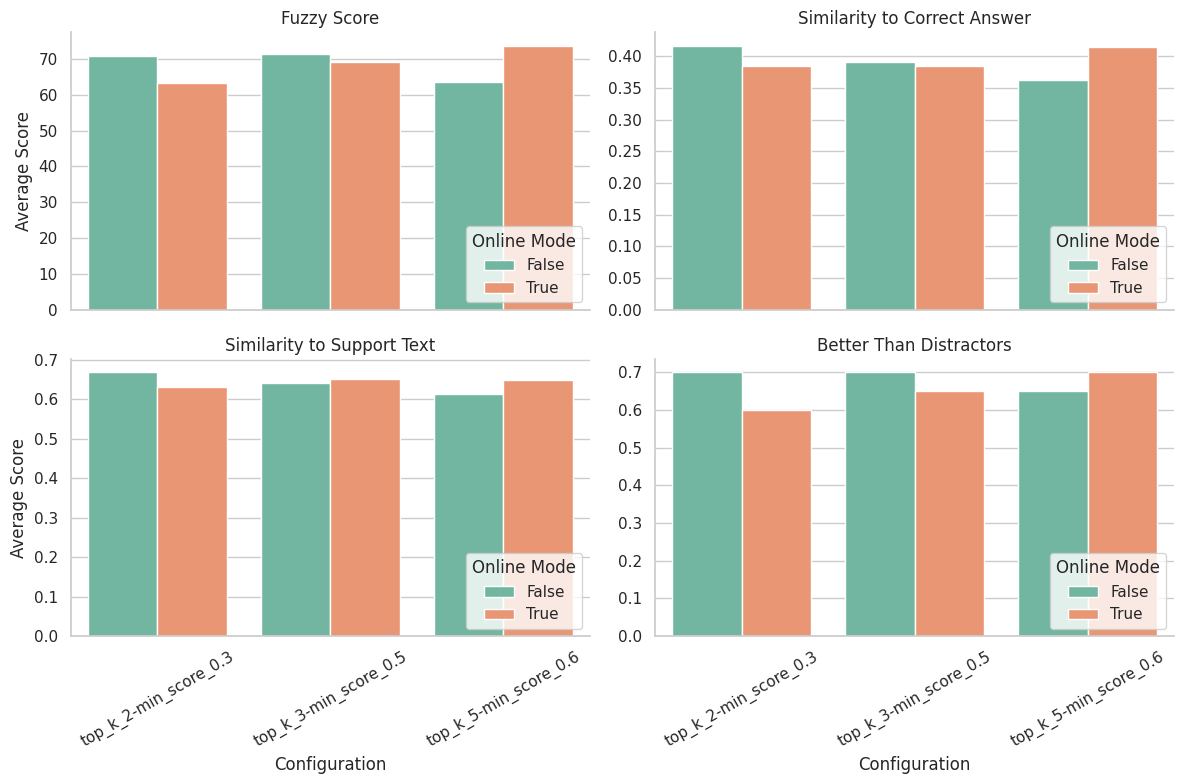

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Melt the original DataFrame
selected_metrics = [
    "Fuzzy Score",
    "Similarity to Correct Answer",
    "Similarity to Support Text",
    "Better Than Distractors"
]

melted_df = summary_df.melt(
    id_vars=["Configuration", "Online?"],
    value_vars=selected_metrics,
    var_name="Metric",
    value_name="Score"
)

# Step 2: Create the FacetGrid for separate plots
g = sns.FacetGrid(
    melted_df,
    col="Metric",
    col_wrap=2,
    height=4,
    aspect=1.5,
    sharey=False
)

g.map_dataframe(
    sns.barplot,
    x="Configuration",
    y="Score",
    hue="Online?",
    palette="Set2",
    dodge=True
)

# Step 3: Beautify
g.set_titles("{col_name}")
g.set_axis_labels("Configuration", "Average Score")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
    ax.legend(title="Online Mode")
    sns.move_legend(ax, "lower right")

plt.tight_layout()
plt.show()

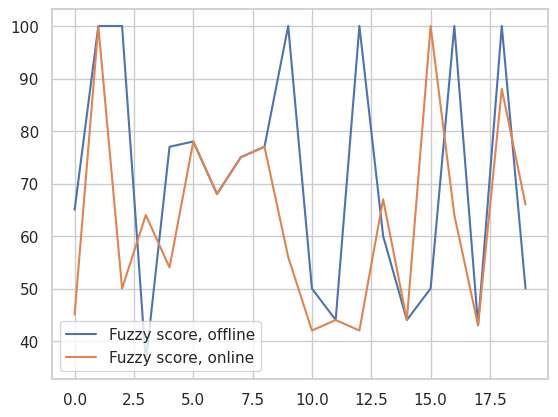

In [71]:
paths = df_info["top_k_2-min_score_0.3"]
for mode, filepath in paths.items():
    df = pd.read_csv(f"evaluation/{filepath}")
    plt.plot(df["fuzzy_score"], label=f"Fuzzy score, {mode}")

plt.legend()
plt.show()

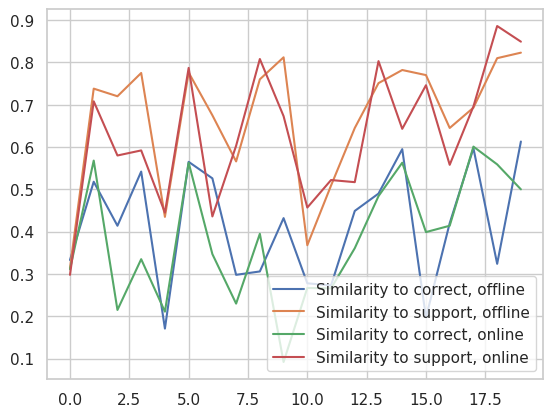

In [73]:
paths = df_info["top_k_2-min_score_0.3"]
for mode, filepath in paths.items():
    df = pd.read_csv(f"evaluation/{filepath}")
    plt.plot(df["sim_to_correct"], label=f"Similarity to correct, {mode}")
    plt.plot(df["sim_to_support"], label=f"Similarity to support, {mode}")

plt.legend()
plt.show()

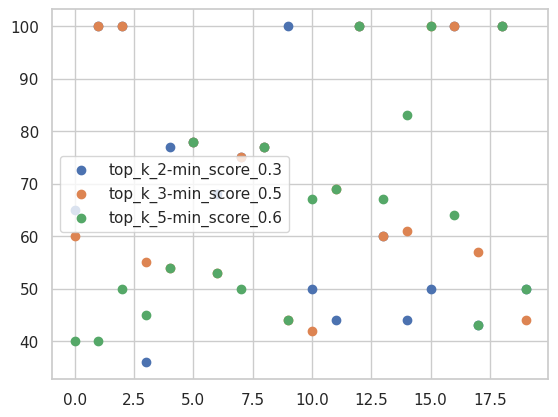

In [76]:
for config_name, paths in df_info.items():
    mode = "offline"
    filepath = paths[mode]
    df = pd.read_csv(f"evaluation/{filepath}")
    X = list(range(20))
    Y = df["fuzzy_score"]
    plt.scatter(X, Y, label=config_name)
    

plt.legend()
sns.move_legend(ax, "lower right")
plt.show()

